In [1]:
!pip install -q transformers
import transformers 
from transformers import GPT2Model #GPT-2 D-o
from transformers import TextGenerationPipeline, AutoTokenizer, AutoModelForCausalLM # pangu E-D
from transformers import MegatronBertConfig, MegatronBertModel, BertTokenizer # erlangshen E-o 

import torch
import numpy as np
import matplotlib.pyplot as plt

     |████████████████████████████████| 5.5 MB 4.0 MB/s 
     |████████████████████████████████| 163 kB 57.6 MB/s 
     |████████████████████████████████| 7.6 MB 66.1 MB/s 


In [2]:
import os
# change dir 
os.chdir("/content/drive/MyDrive/Colab Notebooks")

# Weights visualization

In [184]:
def get_params_plot(model, model_name, sparsity=0):
  # get params dist.
  fig, ax = plt.subplots(figsize=(12,8))
  total_param = torch.cat([p.flatten() for p in model.parameters()]).detach().numpy()
  hist, bins = np.histogram(total_param, bins = np.linspace(-1,1,201)) 
  ax.plot(bins[:-1],hist) 
  plt.title("distribution of all weights(model:{}, sparsity:{}%)".format(model_name, sparsity*100), fontsize=25)
  plt.xlabel("Weight values")
  plt.ylabel("Log Count")
  plt.yscale('log')
  plt.show()
  plt.savefig('{}/figs/vis_all_params_{}_sparcity_{}%.png'.format(os.getcwd(), model_name, sparsity))

  if model_name == 'pangu':
    for child in model.named_children():
      if child[0] == 'transformer':
        model = child[1]
  
  if model_name == 'erlangshen':
    for child in model.named_children():
      if child[0] == 'encoder':
        model = child[1]
  
  # get params dist. in each layer
  for elem in model.named_children():
    if elem[0] == 'h' or elem[0] == 'layer': # erlangshen model uses layer as attr name ...
      fig, ax = plt.subplots(figsize=(12,8))
      for idx, p in enumerate(elem[1].named_children()):
        layer_param = torch.cat([k.flatten() for k in p[1].parameters()]).detach().numpy()
        hist, bins = np.histogram(layer_param, bins = np.linspace(-1,1,201)) 
        ax.plot(bins[:-1],hist,label="{} hidden layer".format(idx)) 
      plt.title("distribution of weights across layers(model:{}, sparsity:{}%)".format(model_name, sparsity*100), fontsize=25)
      plt.xlabel("Weight values")
      plt.ylabel("Log Count")
      plt.yscale('log')
      plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
      plt.show()
      plt.savefig('{}/figs/vis_layers_params_{}_sparsity_{}%.png'.format(os.getcwd(), model_name, sparsity))

##Decoder only model: GPT-2-xl

In [5]:
# gpt2 = GPT2Model.from_pretrained('gpt2-xl')
gpt2 = GPT2Model.from_pretrained('gpt2')
gpt2.num_parameters()

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/548M [00:00<?, ?B/s]

124439808

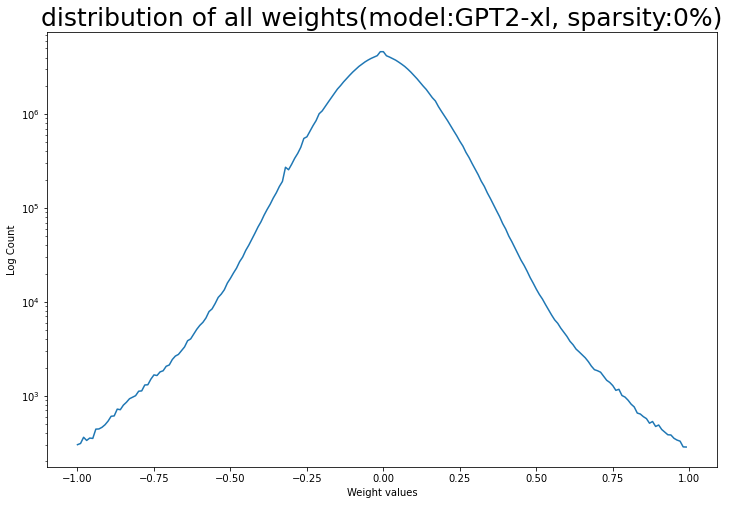

<Figure size 432x288 with 0 Axes>

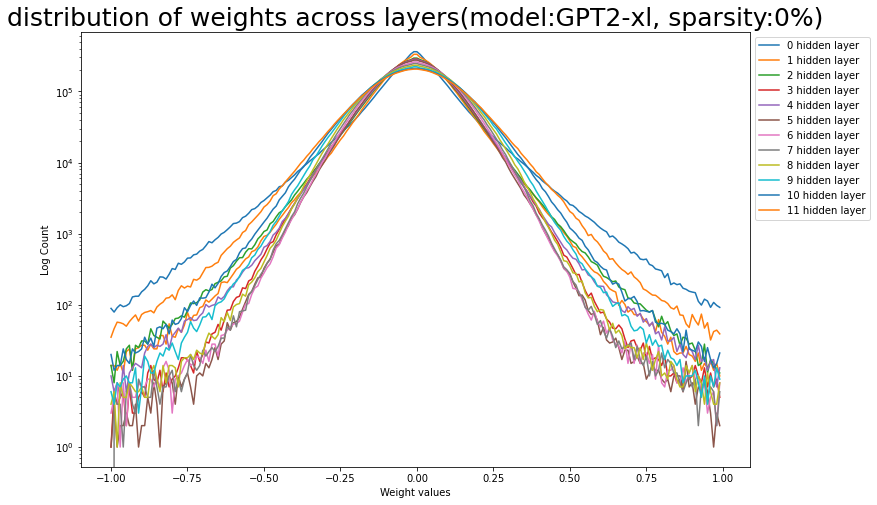

<Figure size 432x288 with 0 Axes>

In [159]:
model_name = 'GPT2-xl'
get_params_plot(gpt2, model_name)

##Encoder-Decoder model: Pangu(盘古)-$\alpha$
[Intro from Huawei](https://www.huaweicloud.com/product/modelarts/pangu.html) 

In [40]:
pangu = AutoModelForCausalLM.from_pretrained("imone/pangu_2_6B", trust_remote_code=True)
pangu.num_parameters()

Downloading:   0%|          | 0.00/968 [00:00<?, ?B/s]

Explicitly passing a `revision` is encouraged when loading a configuration with custom code to ensure no malicious code has been contributed in a newer revision.


Downloading:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

Explicitly passing a `revision` is encouraged when loading a model with custom code to ensure no malicious code has been contributed in a newer revision.


Downloading:   0%|          | 0.00/22.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.5G [00:00<?, ?B/s]

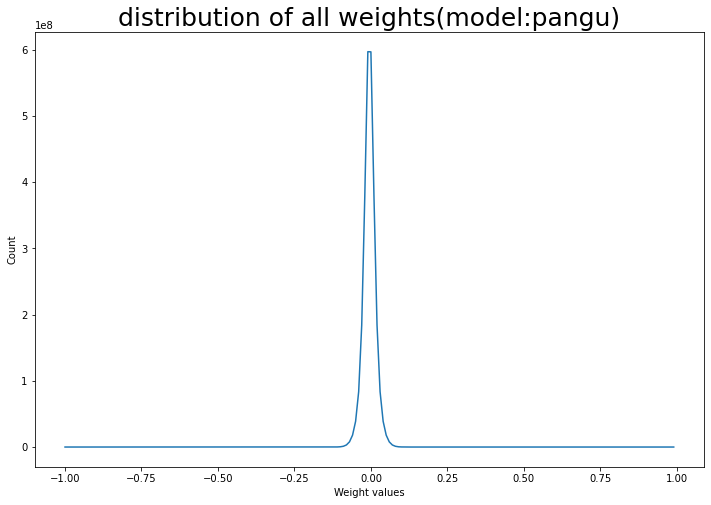

<Figure size 432x288 with 0 Axes>

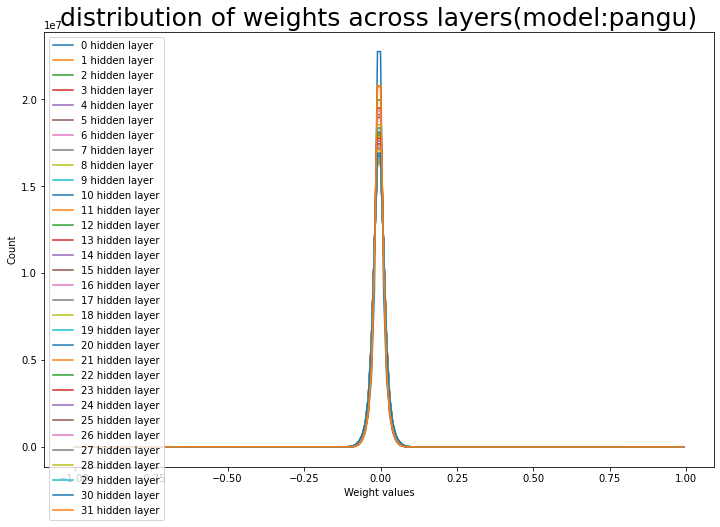

<Figure size 432x288 with 0 Axes>

In [47]:
model_name = 'pangu'
get_params_plot(pangu, model_name)

##Encoder only model: Erlangshen(二郎神)

Bert-based model

[Intro](https://huggingface.co/IDEA-CCNL/Erlangshen-MegatronBert-1.3B)

In [3]:
# tokenizer = BertTokenizer.from_pretrained("IDEA-CCNL/Erlangshen-MegatronBert-1.3B")
# config = MegatronBertConfig.from_pretrained("IDEA-CCNL/Erlangshen-MegatronBert-1.3B")
erlangshen = MegatronBertModel.from_pretrained("IDEA-CCNL/Erlangshen-MegatronBert-1.3B")
erlangshen.num_parameters()

Downloading:   0%|          | 0.00/440 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.52G [00:00<?, ?B/s]

Some weights of the model checkpoint at IDEA-CCNL/Erlangshen-MegatronBert-1.3B were not used when initializing MegatronBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing MegatronBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MegatronBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


1257367552

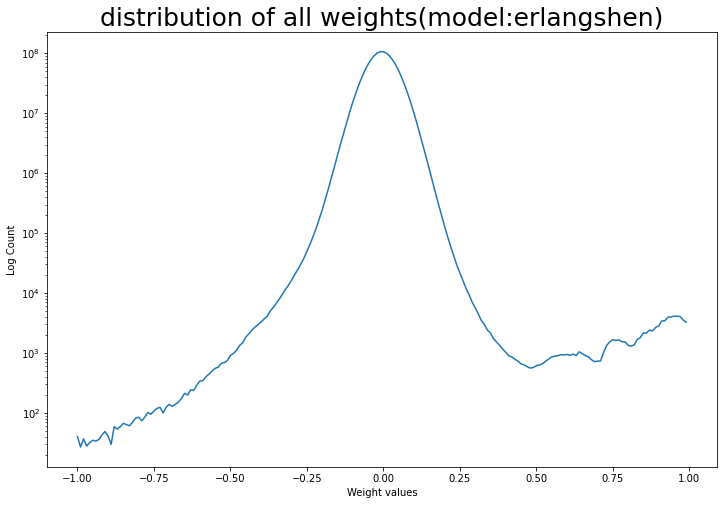

<Figure size 432x288 with 0 Axes>

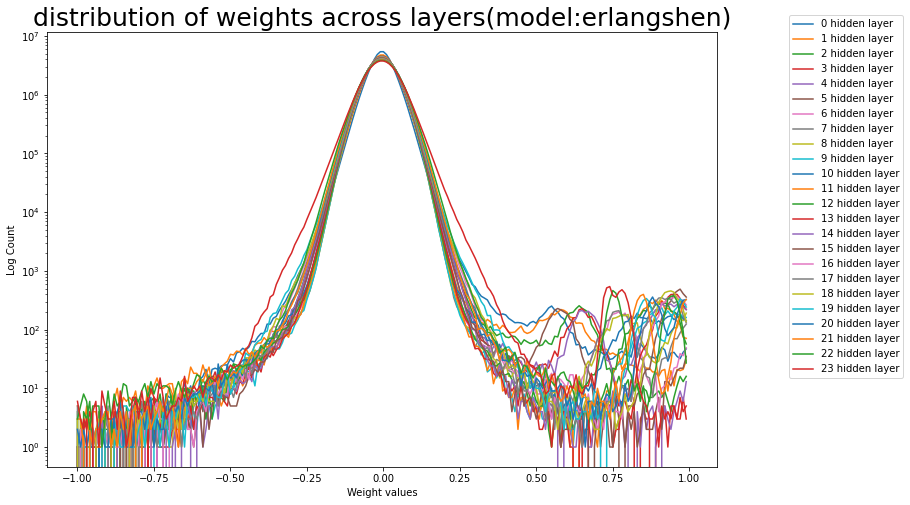

<Figure size 432x288 with 0 Axes>

In [5]:
model_name = 'erlangshen'
get_params_plot(erlangshen, model_name)

# Sparcification

In [56]:
import torch
from torch import nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F
import copy

In [161]:
def prune_model(model, model_name, prune_portion=0.1):
  '''
  using global pruning to prune gpt2, pangu, and erlangshen. 
  '''
  def print_sparsity(module_lst, prune_flag):

    zero_params_count = sum([torch.sum(module[0].weight == 0) for module in module_lst])
    total_params_count = sum([module[0].weight.nelement() for module in module_lst])

    print(
        "Global sparsity of model: {} in hidden layers {} pruning: {:.2f}%".format(prune_flag, model_name,
                                                    100. * float(zero_params_count)
                                                        / float(total_params_count)
                                                    )
        )
    return None
    
  if model_name == 'pangu':
    modules = model.transformer.h.modules()
  elif model_name == 'erlangshen':
    modules = model.encoder.layer.modules()
  else:
    modules = model.h.modules()

  module_lst = []
  for module in modules:
    if hasattr(module, 'weight'):
      module_lst.append((module, 'weight'))

  print_sparsity(module_lst, prune_flag = 'before')
  
  prune.global_unstructured(module_lst, 
                            pruning_method=prune.L1Unstructured, 
                            amount=prune_portion)
  for module, attr in module_lst: 
    prune.remove(module, attr)

  print_sparsity(module_lst, prune_flag = 'after')
  return model

In [ ]:
# gpt2 = GPT2Model.from_pretrained('gpt2')
# pangu = AutoModelForCausalLM.from_pretrained("imone/pangu_2_6B", trust_remote_code=True)
# erlangshen = MegatronBertModel.from_pretrained("IDEA-CCNL/Erlangshen-MegatronBert-1.3B")

model_names = ['GPT2-xl', 'pangu', 'erlangshen']
model_lst = [gpt2, pangu, erlangshen]
sparsity = [0.1, 0.5, 0.9, 0.95, 0.99] 

print("Start sparsifying...")
for model, model_name in zip(model_lst, model_names):
  for prune_proportion in sparsity:
    target_model = copy.deepcopy(model)
    target_model = prune_model(target_model)
    get_params_plot(target_model, model_name, prune_proportion)
    target_model.save_pretrained("{}/models/{}_sparsity_{}".format(os.getcwd(), 
                                                            model_name,
                                                            prune_proportion*100,
                                                            ))
    print("model {} with sparsity {} saved".format(model_name, prune_proportion * 100))
    
print("Sparsification completed!")

# Measure model size

Method from [here](https://discuss.pytorch.org/t/finding-model-size/130275/5)

In [ ]:
# TBD
model = models.resnet18()
param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))

# Evaluation on Benchmarks

For GPT2: XNLI and CLM

For pangu, erlangshen: XNLI and CLUE